In [1]:
# AMDG
import stim
import numpy as np
import itertools
from copy import copy
from copy import deepcopy
from random import random
import sys
import matplotlib.pyplot as plt
from random import randint

todo:

* Bug: Make sure identity error doesn't affect the Bell pair creation
* Update single qubit errors to take twirling into account as well


Interesting result:</br>

In the case where we have multiple rounds of purification, the Fidelity appears to get **worse** with the number of rounds. My hypothesis is that the z-error is poisoning the circuit, since individual z-contributions from all of the input pairs go uncorrected.</br>

This claim is supported by the fact that the fidelity improves when num_rounds = 1. The purification is definitely correcting at each purification step. But doesn't this contradict principle of deferred measurement? Need to investigate this further.

Maybe not. If you're adding exponentially more resource overhead then uncorrectable error is going to compound exponentially. Simplest way to check this is to verify that the circuit corrects x-dephasing noise for the multi-round case.

I think this is where twirling comes into the picture. We want to transform z depolarizing errors into x after each purification block. How do we do this?

### Circuit Construction Methods

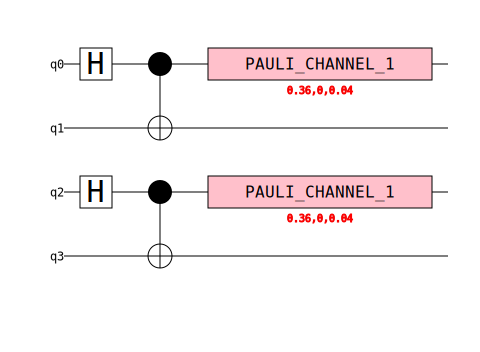

In [95]:
"""
Initialize Bell pairs with some error type
"""
def initialize_pairs(num_qubits, F_err=0.0, bell_error_type="DEPOLARIZE1", z_error_ratio=None):
    circuit = stim.Circuit()
    hadamards = range(num_qubits)[::2]
    cnots = range(num_qubits)
    circuit.append_operation("H", hadamards)
    circuit.append_operation("CNOT", cnots)
    if z_error_ratio != None: # Overwrite bell_error_type with custom x,z error channel
        circuit.append_operation("PAULI_CHANNEL_1", hadamards, [F_err * (1-z_error_ratio), 0, F_err * z_error_ratio])
    elif F_err != 0: circuit.append_operation(bell_error_type, hadamards, F_err)
    return circuit

q = 4
c = initialize_pairs(q, F_err=0.4, bell_error_type="DEPOLARIZE1", z_error_ratio=0.1)
c.diagram(type="timeline-svg")

In [21]:
def add_bilateral_cnots(circuit, pairs, cnot_err=0.0):
    # pairs = (1). a1 a2 b1 b2, (2). a1 a2 b1 b2, ...
    # cnots: (1). b1 a1 b2 a2, (2). b1 a1 b2 a2, ....
    cnots = copy(pairs)
    for twopair in range(len(cnots))[::4]:
        cnots[twopair + 0], cnots[twopair + 2] = cnots[twopair + 2], cnots[twopair + 0] # a1 a2 b1 b2 -> b1 a2 a1 b2
        cnots[twopair + 1], cnots[twopair + 2] = cnots[twopair + 2], cnots[twopair + 1] # b1 a2 a1 b2 -> b1 a1 a2 b2
        cnots[twopair + 2], cnots[twopair + 3] = cnots[twopair + 3], cnots[twopair + 2] # b1 a1 a2 b2 -> b1 a1 b2 a2
    # This is good to return at this point, but additional reordering is makes circuit drawing more compact
    halfA = [i for pair in zip(cnots[::4], cnots[1::4]) for i in pair]
    halfB = [i for pair in zip(cnots[2::4], cnots[3::4]) for i in pair]
    if cnot_err != 0: circuit.append_operation("DEPOLARIZE2", halfA + halfB, cnot_err)
    circuit.append_operation("CNOT", halfA + halfB)
    return

In [22]:
def add_conditional_teleportation(circuit, num_purifiers, cnot_err=0.0):
    num_qubits = circuit.num_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    qubits_to_teleport = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier == 0 or (i+2) % qubits_per_purifier == 0]
    halfA = qubits_to_teleport[::2]
    halfB = qubits_to_teleport[1::2]
    targetA = np.ones(len(halfA), int) * (num_qubits)
    targetB = np.ones(len(halfB), int) * (num_qubits + 1)
    cnots = [i for pair in zip(halfA, targetA, halfB, targetB) for i in pair]
    if cnot_err != 0: circuit.append_operation("DEPOLARIZE2", cnots, cnot_err)
    circuit.append_operation("CNOT", cnots)
    return

In [23]:
full_gate_list = [
    "I",
    "X",
    "Y",
    "Z",
    "C_XYZ",
    "C_ZYX",
    "H",
    "H_XY",
    "H_XZ",
    "H_YZ",
    "S",
    "SQRT_X",
    "SQRT_X_DAG",
    "SQRT_Y",
    "SQRT_Y_DAG",
    "SQRT_Z",
    "SQRT_Z_DAG",
    "S_DAG"
]

"""
Add twirling operations
"""
def add_twirling(circuit, num_iterations, qubit_positions, gate_set=full_gate_list):
    # Transform from mostly phi_plus to psi_minus
    circuit.append_operation("X", qubit_positions[::2])
    circuit.append_operation("Z", qubit_positions[::2])
    for i in range(num_iterations):
        # equal probability applications:
        circuit.append(gate_set[randint(0, len(gate_set)-1)], qubit_positions)
    # Transform back to phi_plus
    circuit.append_operation("Z", qubit_positions[::2])
    circuit.append_operation("X", qubit_positions[::2])
    return circuit

In [24]:
def add_measurement_resets(circuit, num_purifiers):
    ancilla_qubits = 2
    num_qubits = circuit.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    measure_qubits = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier != 0 and (i+2) % qubits_per_purifier != 0]
    circuit.append_operation("MR", measure_qubits)
    return circuit

In [25]:
"""
Given a list of measurements for the circuit, return which (if any) purification blocks were successful.
A purification block is successful if all consecutive measurements in that block have the same parity.
"""
def which_purifications_succeeded(simulator, num_purifiers, manual_debug_input = None, debug = False):
    ancilla_qubits = 2
    num_qubits = simulator.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    measurements_per_purifier = qubits_per_purifier - ancilla_qubits
    measurements = simulator.current_measurement_record()
    if manual_debug_input != None: 
        measurements = manual_debug_input
    successful_purifications = []
    for pidx in range(num_purifiers):
        measurement_slice = measurements[pidx * measurements_per_purifier : measurements_per_purifier * (pidx + 1)]
        purification_success = all(measurement_slice[i] == measurement_slice[i+1] for i in range(0, len(measurement_slice) - 1, 2))
        if purification_success: successful_purifications.append(pidx)
    if debug == True: 
        print(f"Purification measurements: {measurements}")
        print(f"successful purifications: {successful_purifications}")
    return successful_purifications

In [8]:
"""
Return correction circuit with teleportation measurements
"""
def teleport_with_correction(circuit, simulator, num_purifiers, purifier_successes, single_gate_err=0.0, debug=False):
    
    teleport_circuit = stim.Circuit()
    
    # Custom iterators for later
    def iterate_pairs(lst):
        for i in range(0, len(lst), 2):
            yield lst[i:i+2]
            
    def iterate_two_pairs(lst1, lst2):
        for i in range(0, len(lst1), 2):
            yield (lst1[i:i+2], lst2[i:i+2])
    
    ancilla_qubits = 2
    num_qubits = circuit.num_qubits - ancilla_qubits
    qubits_per_purifier = int(num_qubits / num_purifiers)
    qubits_to_measure = [i for i in range(0, num_qubits) if (i+1) % qubits_per_purifier == 0 or (i+2) % qubits_per_purifier == 0]
    
    purifier = purifier_successes[0] # Choose the first good purifier
    pair_to_teleport = [qubits_to_measure[2 * purifier], qubits_to_measure[2 * purifier + 1]]
    for pair in iterate_pairs(qubits_to_measure):
        if pair == pair_to_teleport:
            teleport_circuit.append("MX", pair)
            teleport_circuit.append("R", pair)
        else:
            teleport_circuit.append("M", pair)
            teleport_circuit.append("R", pair)    
    
    simulator.do(teleport_circuit)
    circuit.__iadd__(teleport_circuit)
    
    # Part 2: Add error correcting gates (NB: Measurement of 0 == True, Measurement of 1 == False)
    correction_circuit = stim.Circuit()
    tf = {True:0, False:1}
    outanc = [num_qubits, num_qubits + 1]
    num_tele_measurements = len(qubits_to_measure)
    tele_measurements = simulator.current_measurement_record()[-num_tele_measurements:]
    if debug == True: 
        print(f"qubits to measure in teleportation step: {qubits_to_measure}")
        print(f"teleportation measurements: {tele_measurements}")
    # Iterate over the last most recent measurements
    for qubit_pair, measurement_pair in iterate_two_pairs(qubits_to_measure, tele_measurements):
        if qubit_pair == pair_to_teleport:
            # Z measurements
            correction_circuit.append("Z", outanc[0]) if measurement_pair[0] else correction_circuit.append("I", outanc[0]);
            correction_circuit.append("Z", outanc[1]) if measurement_pair[1] else correction_circuit.append("I", outanc[1]);
        else:
            # X measurements
            correction_circuit.append("X", outanc[0]) if measurement_pair[0] else correction_circuit.append("I", outanc[0]);
            correction_circuit.append("X", outanc[1]) if measurement_pair[1] else correction_circuit.append("I", outanc[1]);
    
    # Error injection for correction circuit
    if single_gate_err != 0: correction_circuit = add_1gate_error(correction_circuit, single_gate_err)
    
    simulator.do(correction_circuit)
    circuit.__iadd__(correction_circuit)
    return

### Error injection methods

H 0
CX 0 1
Y 0 2
CX 0 1 2 3
SWAP 1 2
DEPOLARIZE1(0.8) 0 3


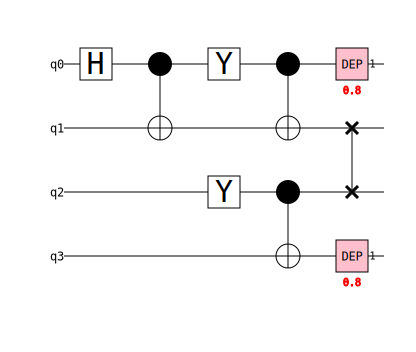

In [26]:
"""
Parse a stim circuit and add single qubit depolarizing errors for each no-op in the circuit. 
(Excluding state preperation)
""" 
def add_identity_error(circuit, prob):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for opidx, op in enumerate(circuit):
        new_circuit.append(op)
        if opidx > 2:
            qubits = set(range(num_qubits))
            active_qubits = set([x.value for x in op.targets_copy()])
            noop_qubits = list(qubits.difference(active_qubits))
            if len(noop_qubits) > 0: new_circuit.append("DEPOLARIZE1", noop_qubits, prob)
    return new_circuit


test = stim.Circuit()
test.append("H", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test_with_error = add_identity_error(test, 0.8)
print(test_with_error)
test_with_error.diagram(type="timeline-svg")

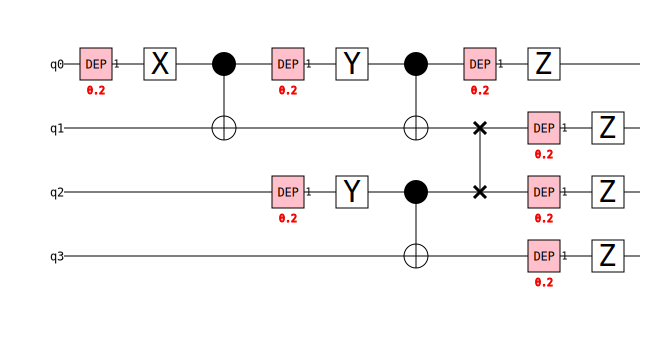

In [36]:
"Parse a stim circuit and add single qubit depolarizing errors BEFORE each single qubit gate"
def add_1gate_error(circuit, prob, gates_with_error=full_gate_list):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for op in circuit:
        strop = op.__str__() # op to string
        gate_arg = strop.split()[0] # Filter out first argument
        if gate_arg in set(gates_with_error):
            error_qubits = strop.split()[1:] # list of strings
            error_qubits = [eval(i) for i in error_qubits] # list of ints
            if len(error_qubits) > 0: new_circuit.append("DEPOLARIZE1", error_qubits, prob)
        new_circuit.append(op)
    return new_circuit


test = stim.Circuit()
test.append("X", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test.append("Z",[0,1,2,3])
test_with_error = add_1gate_error(test, 0.2)
# print(test_with_error)
test_with_error.diagram(type="timeline-svg")

In [28]:
def add_measurement_error(measurements, prob):
    new_measurements = []
    error_locations = []
    for idx, m in enumerate(measurements):
        if random() <= prob:
            new_measurements.append(not m)
            error_locations.append(idx)
        else:
            new_measurements.append(m)
    return new_measurements, error_locations

print(add_measurement_error([True, False, True], 1.0))
print(add_measurement_error([True, False, True], 0.0))
print(add_measurement_error([True, False, True], 0.5))

([False, True, False], [0, 1, 2])
([True, False, True], [])
([False, True, False], [0, 1, 2])


### Statevector methods

In [29]:
"""
Extracts the statevector corresponding to the output pair and calculate the fidelity with respect to phi plus

This function runs under the assumption that the Bell pair is located at the last 2 qubits of the circuit.
"""
def bell_fidelity(simulator):
    q = simulator.num_qubits
    stabs = simulator.canonical_stabilizers()
    bell_stabs = [] #stabilizers for reduced state (presumably a bell pair)
    for s in [stabs[-2], stabs[-1]]:
        stab_string = s.__str__()
        phase = stab_string[0] 
        qubits = stab_string[q-1] + stab_string[q]
        bell_stabs.append(stim.PauliString(phase+qubits))
    bell_simulator = stim.TableauSimulator()
    bell_simulator.set_state_from_stabilizers(bell_stabs)
    ideal_state_vector = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]
    return np.inner(bell_simulator.state_vector(), ideal_state_vector)

In [30]:
# bootleg version -- exercise with caution
# def bell_fidelity(simulator):
#     q = simulator.num_qubits
#     stabs = simulator.canonical_stabilizers()
#     phaseXX = stabs[-2].__str__()[0]
#     phaseZZ = stabs[-1].__str__()[0]
#     bell_stabs = [stim.PauliString(phaseXX + "XX"), stim.PauliString(phaseZZ + "ZZ")]
#     bell_simulator = stim.TableauSimulator()
#     bell_simulator.set_state_from_stabilizers(bell_stabs)
#     ideal_state_vector = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]
#     return np.inner(bell_simulator.state_vector(), ideal_state_vector)

### Main purification protocol

Purification measurements: [False, False, False, False, False, False]
successful purifications: [0]
qubits to measure in teleportation step: [6, 7]
teleportation measurements: [True, False]
Purification successful? :: True
Output pair fidelity: (0.9999999828857289+0j)


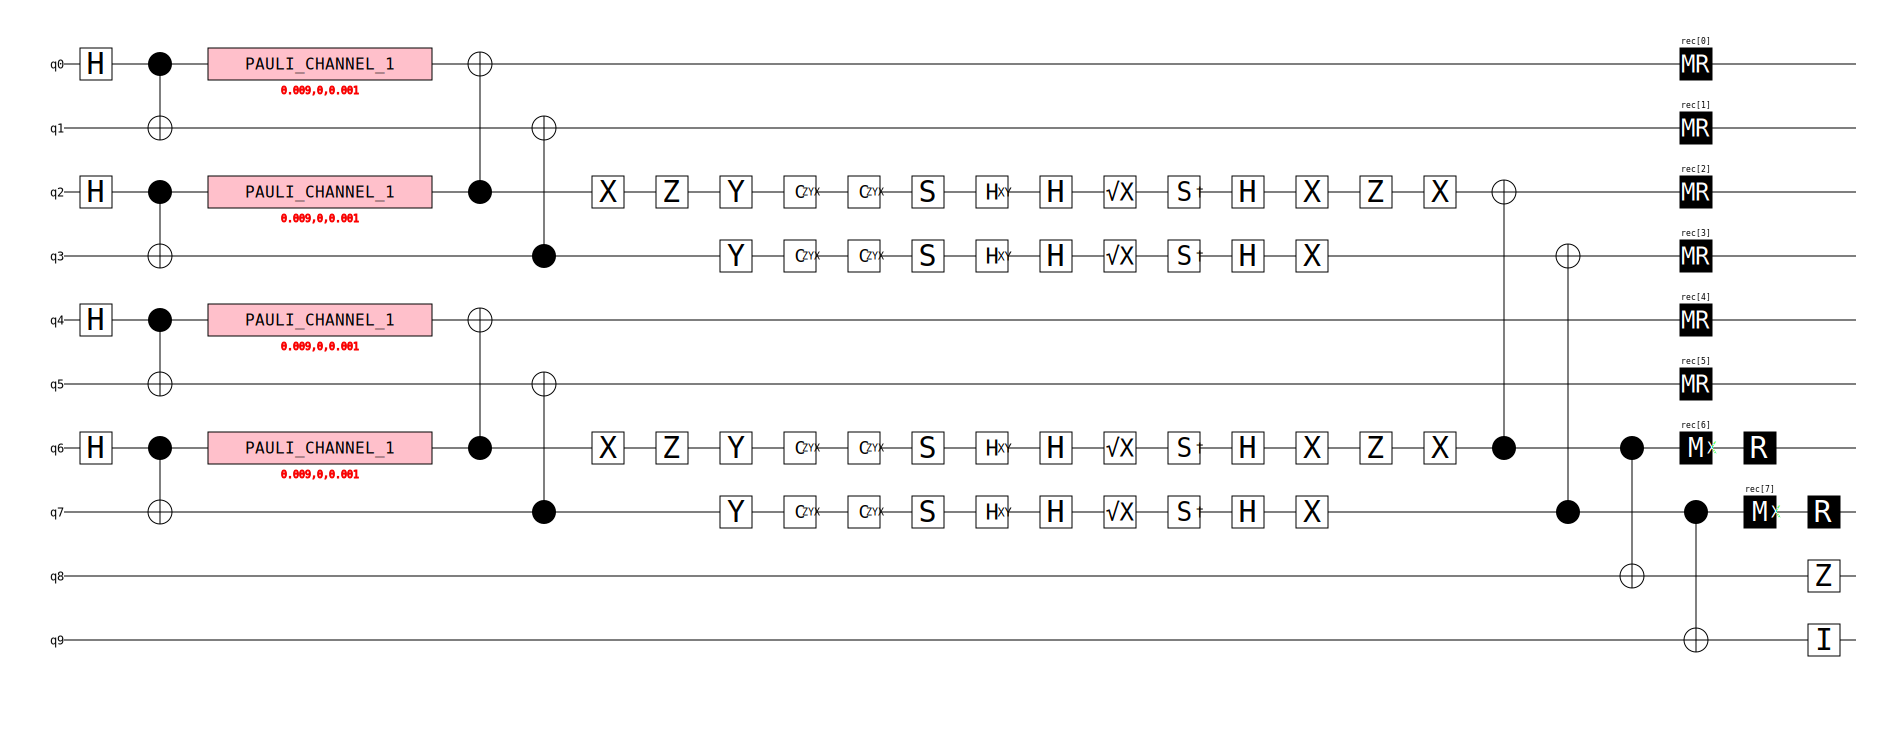

In [69]:
"""
Simulates a multi_round purification circuit with errors.

Returns a circuit level description, a True/False on if the protocol was successful and the corresponding Fidelity
(Defaults to 0 if purification was unsuccesful)
"""
def multi_round_purification(num_rounds=1, num_purifiers=2, F_err=0.0, ierr=0.0, cnot_err=0.0, single_gate_err=0.0, measurement_err=0.0,
                             bell_err_type="DEPOLARIZE1", z_error_ratio=None, debug=False, with_twirling=False):
    
    num_qubits = num_purifiers * 2**(num_rounds + 1)
    circuit = initialize_pairs(num_qubits, F_err, bell_err_type, z_error_ratio)
    # Iterate here: Calculate the pair list for each level, remove ints from list, add them to another list for measurements
    pairs = list(range(num_qubits))
    for i in range(num_rounds):
        add_bilateral_cnots(circuit, pairs, cnot_err)
        pairs = [i for pair in zip(pairs[2::4], pairs[3::4]) for i in pair]
        if i != (num_rounds-1) and with_twirling == True: add_twirling(circuit, 10, pairs)
    # Add conditional teleportation
    add_conditional_teleportation(circuit, num_purifiers, cnot_err)
    # Add identity errors:
    if ierr != 0: circuit = add_identity_error(circuit, ierr)
    # Measure everything but the last two qubits of each purifier:
    add_measurement_resets(circuit, num_purifiers)
    simulator = stim.TableauSimulator()
    simulator.do(circuit)
    purifier_successes = which_purifications_succeeded(simulator, num_purifiers, debug=debug)
    if len(purifier_successes) == 0:
        return circuit, False, 0
    
    ### PHASE 2: ### teleportation measurement with correction:
    # generate_correction_circuit(circuit, purifier_successes)
    teleport_with_correction(circuit, simulator, num_purifiers, purifier_successes, single_gate_err, debug=debug)
    F = bell_fidelity(simulator)
    return circuit, True, F

circuit, outcome, F = multi_round_purification(num_rounds=2, num_purifiers=1, F_err=0.01, debug=True, ierr = 0.0, cnot_err=0.0, 
                                               single_gate_err=0.00, bell_err_type="X_ERROR", z_error_ratio=0.1,
                                               with_twirling=True)
print(f"Purification successful? :: {outcome}")
print(f"Output pair fidelity: {F}")
circuit.diagram(type="timeline-svg")

### Visualisation:

In [80]:
# I want to specify a particular error type, and then increment over that error, leaving everything else error_free.
class ErrorProbs:
    def __init__(self, F_err=0., ierr=0., cnot_err=0., single_gate_err=0., measurement_err=0., bell_err_type="DEPOLARIZE1",
                z_error_ratio=None):
        valid_error_types = ["DEPOLARIZE1", "X_ERROR", "Y_ERROR", "Z_ERROR"]
        if bell_err_type not in valid_error_types: raise Exception(f"Unsupported Bell error type. Please pick from {bell_err_type}")
        self.F_err = F_err
        self.ierr = ierr
        self.cnot_err = cnot_err
        self.single_gate_err = single_gate_err
        self.measurement_err = measurement_err
        self.bell_err_type = bell_err_type
        self.z_error_ratio = z_error_ratio
    
    def __str__(self):
        return f"""F_err: {self.F_err}
ierr: {self.ierr}
cnot_err: {self.cnot_err}
single_gate_err: {self.single_gate_err}
measurement_err: {self.measurement_err}
bell_err_type: {self.bell_err_type}
z_error_ratio: {self.z_error_ratio}
"""

In [78]:
# Can we extract attributes of class as dictionary? Try this
def average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs, inc=100, with_twirling=False, quiet=False):
    ave_fidelity = 0
    num_misses = 0
    for i in range(num_trials):
        if quiet == False and i % inc == 0: print(f"Running trial {i}")
        kwargs = vars(error_probs)
        circuit, status, F = multi_round_purification(num_rounds=num_rounds,
                                                      num_purifiers=num_purifiers, 
                                                      **kwargs,
                                                      debug=False,
                                                      with_twirling=with_twirling)
        if status == False:
            num_misses += 1
        else:
            ave_fidelity += F
    if quiet == False:
        print(f"\nSuccess rate: {(num_trials - num_misses)*100/num_trials}%")
    ave_fidelity = ave_fidelity / (num_trials - num_misses)
    return ave_fidelity

In [71]:
# def average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs, inc=100, with_twirling=False, quiet=False):
#     ave_fidelity = 0
#     num_misses = 0
#     for i in range(num_trials):
#         if quiet == False and i % inc == 0: print(f"Running trial {i}")
#         circuit, status, F = multi_round_purification(num_rounds=num_rounds,
#                                                       num_purifiers=num_purifiers, 
#                                                       F_err = error_probs.F_err, 
#                                                       ierr = error_probs.ierr,
#                                                       cnot_err = error_probs.cnot_err,
#                                                       single_gate_err = error_probs.single_gate_err, 
#                                                       measurement_err = error_probs.measurement_err, 
#                                                       bell_err_type = error_probs.bell_err_type,
#                                                       debug=False,
#                                                       with_twirling=with_twirling)
#         if status == False:
#             num_misses += 1
#         else:
#             ave_fidelity += F
#     if quiet == False:
#         print(f"\nSuccess rate: {(num_trials - num_misses)*100/num_trials}%")
#     ave_fidelity = ave_fidelity / (num_trials - num_misses)
#     return ave_fidelity

In [81]:
# Test average_pair_fidelity
F = 0.95
F_err = 1-F
err1 = ErrorProbs(F_err=F_err, bell_err_type="DEPOLARIZE1")
average_pair_fidelity(num_trials = 1000, num_rounds=5, num_purifiers=2, error_probs=err1, 
                      inc = 500, with_twirling=True, quiet=False)

Running trial 0
Running trial 500

Success rate: 36.6%


(0.9918032617145397+0j)

In [93]:
# Test average_pair_fidelity
F = 0.95
F_err = 1-F
err1 = ErrorProbs(F_err=F_err, bell_err_type="DEPOLARIZE1")
average_pair_fidelity(num_trials = 5000, num_rounds=6, num_purifiers=1, error_probs=err1, 
                      inc = 5000, with_twirling=True, quiet=False)

Running trial 0
Running trial 500
Running trial 1000
Running trial 1500
Running trial 2000
Running trial 2500
Running trial 3000
Running trial 3500
Running trial 4000
Running trial 4500
Running trial 5000
Running trial 5500
Running trial 6000
Running trial 6500
Running trial 7000
Running trial 7500
Running trial 8000
Running trial 8500
Running trial 9000
Running trial 9500
Running trial 10000
Running trial 10500
Running trial 11000
Running trial 11500
Running trial 12000
Running trial 12500
Running trial 13000
Running trial 13500
Running trial 14000
Running trial 14500
Running trial 15000
Running trial 15500
Running trial 16000
Running trial 16500
Running trial 17000
Running trial 17500
Running trial 18000
Running trial 18500
Running trial 19000
Running trial 19500
Running trial 20000
Running trial 20500
Running trial 21000
Running trial 21500
Running trial 22000
Running trial 22500
Running trial 23000
Running trial 23500
Running trial 24000
Running trial 24500
Running trial 25000
Runn

(0.9924852218764195+0j)

In [98]:
# Test average_pair_fidelity
F = 0.95
F_err = 1-F
err1 = ErrorProbs(F_err=F_err, bell_err_type="DEPOLARIZE1")
average_pair_fidelity(num_trials = 10000, num_rounds=6, num_purifiers=3, error_probs=err1, 
                      inc = 5000, with_twirling=True, quiet=False)

Running trial 0
Running trial 5000

Success rate: 10.91%


(0.9935838510065301+0j)

### Methods for plotting

In [91]:
def plot_fidelity_with_error(num_trials, error_type, num_rounds=2, num_purifiers=4, inc=0.05, F_err=0., 
                             bell_err_type = "DEPOLARIZE1", maxval=1.):
    valid_error_types = ["F", "ierr", "cnot_err", "single_gate_err", "measurement_err"]
    if error_type not in valid_error_types:
        raise Exception(f"Please select a valid error type from: {valid_error_types}")
    error_probabilities = np.arange(0., maxval, inc)
    fidelities = []
    for p in error_probabilities:
        print(f"Sampling for {p}")
        kwargs = {error_type: p, "bell_err_type":bell_err_type, "F_err":F_err}
        error_probs = ErrorProbs(**kwargs)
        fidelity = average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs=error_probs, 
                                         with_twirling=True, quiet=True)
        fidelities.append(fidelity)
        
    plt.plot(error_probabilities, fidelities)
    plt.xlabel("Probability of error")
    plt.ylabel("Pair fidelity")
    plt.title(f"{error_type} vs. pair fidelity")
    plt.show()
    return

### Fidelity vs number of Purifying blocks

### Fidelity vs different Error Types

Sampling for 0.0
Sampling for 0.05
Sampling for 0.1
Sampling for 0.15000000000000002


/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


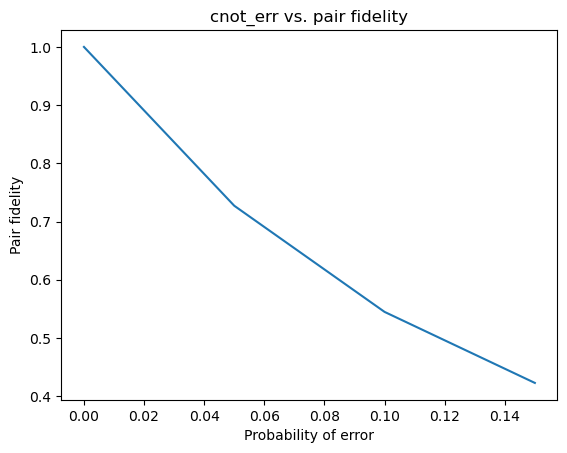

In [92]:
plot_fidelity_with_error(5000, "cnot_err", num_rounds=3, num_purifiers=4, maxval=0.2)

Sampling for 0.0
Sampling for 0.0001
Sampling for 0.0002
Sampling for 0.00030000000000000003
Sampling for 0.0004
Sampling for 0.0005
Sampling for 0.0006000000000000001
Sampling for 0.0007
Sampling for 0.0008
Sampling for 0.0009000000000000001


/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


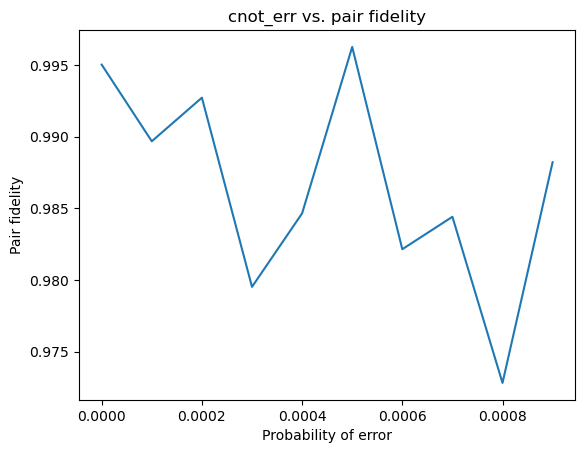

In [26]:
plot_fidelity_with_error(5000, "cnot_err", num_rounds=6, num_purifiers=3, maxval=0.001, inc=0.0001, F_err = 0.05)

### Fidelity vs Z_error_ratio for different initial Fidelities and different purification depths

In [103]:
"""
maxval: Maximum value to calculate for
"""
def plot_fidelity_over_z_error_ratio(num_trials, num_rounds, num_purifiers, inc=0.01, F_err=0.05, maxval=0.333):
    error_probabilities = np.arange(0., maxval, inc)
    fidelities = []
    for p in error_probabilities:
        print(f"Sampling for {p}")
        kwargs = {"z_error_ratio": p, "F_err":F_err}
        error_probs = ErrorProbs(**kwargs)
        fidelity = average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs=error_probs, 
                                         with_twirling=True, quiet=True)
        fidelities.append(fidelity)
        
    plt.plot(error_probabilities, fidelities)
    plt.yscale('log',base=10)
    plt.xlabel("Ratio of Z error to X")
    plt.ylabel("Pair fidelity")
    plt.title(f"Z error rate vs. pair fidelity")
    plt.show()
    return

Sampling for 0.0
Sampling for 0.01
Sampling for 0.02
Sampling for 0.03
Sampling for 0.04
Sampling for 0.05
Sampling for 0.06
Sampling for 0.07
Sampling for 0.08
Sampling for 0.09
Sampling for 0.1
Sampling for 0.11
Sampling for 0.12
Sampling for 0.13
Sampling for 0.14
Sampling for 0.15
Sampling for 0.16
Sampling for 0.17
Sampling for 0.18
Sampling for 0.19
Sampling for 0.2
Sampling for 0.21
Sampling for 0.22
Sampling for 0.23
Sampling for 0.24
Sampling for 0.25
Sampling for 0.26
Sampling for 0.27
Sampling for 0.28
Sampling for 0.29
Sampling for 0.3
Sampling for 0.31
Sampling for 0.32


/home/hudson/anaconda3/envs/qiskit_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


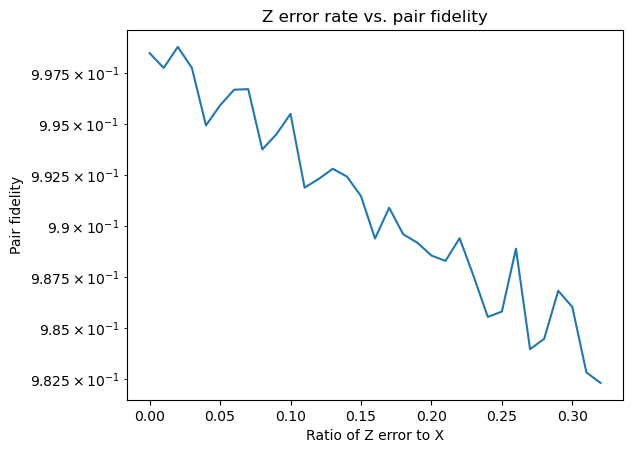

In [106]:
plot_fidelity_over_z_error_ratio(10000, 3, 1, inc=0.01, F_err=0.05, maxval=0.33)

---------- Sampling for num_rounds = 3, num_purifiers = 1 ----------
Sampling for 0.0
Sampling for 0.05
Sampling for 0.1
Sampling for 0.15
Sampling for 0.2
Sampling for 0.25
Sampling for 0.3
---------- Sampling for num_rounds = 4, num_purifiers = 1 ----------
Sampling for 0.0
Sampling for 0.05
Sampling for 0.1
Sampling for 0.15
Sampling for 0.2
Sampling for 0.25
Sampling for 0.3
---------- Sampling for num_rounds = 5, num_purifiers = 1 ----------
Sampling for 0.0
Sampling for 0.05
Sampling for 0.1
Sampling for 0.15
Sampling for 0.2
Sampling for 0.25
Sampling for 0.3


ValueError: x and y must have same first dimension, but have shapes (17,) and (34,)

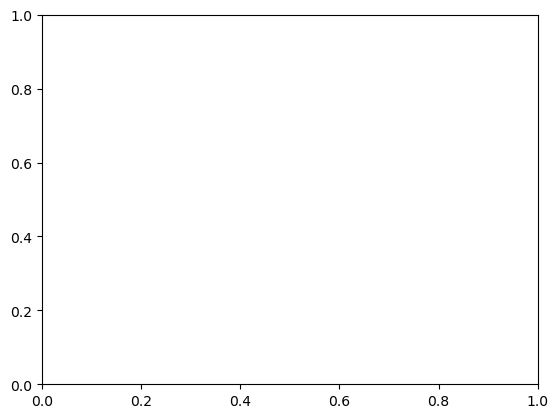

In [115]:
"""
maxval: Maximum value to calculate for
"""
def fidelity_over_z_error_ratio(num_trials, num_rounds, num_purifiers, inc=0.01, F_err=0.05, maxval=0.333):
    error_probabilities = np.arange(0., maxval, inc)
    fidelities = []
    print(f"---------- Sampling for num_rounds = {num_rounds}, num_purifiers = {num_purifiers} ----------")
    for idx, p in enumerate(error_probabilities):
        if idx % 5 == 0: print(f"Sampling for {p}")
        kwargs = {"z_error_ratio": p, "F_err":F_err}
        error_probs = ErrorProbs(**kwargs)
        fidelity = average_pair_fidelity(num_trials, num_rounds, num_purifiers, error_probs=error_probs, 
                                         with_twirling=True, quiet=True)
        fidelities.append(fidelity)
    return fidelities

maxval = 0.333
inc = 0.02
error_probabilities = np.arange(0., maxval, inc)
fidelity_data = []
rounds_to_sample = [3, 4, 5]

for num_rounds in rounds_to_sample:
    fidelities = fidelity_over_z_error_ratio(50000, num_rounds, 1)
    fidelity_data.append(fidelities)

for fidelities in fidelity_data:
    plt.plot(error_probabilities, fidelities)
    
# plt.yscale('log',base=10)
plt.xlabel("Ratio of Z error to X")
plt.ylabel("Pair fidelity")
plt.title(f"Z error rate vs. pair fidelity")
plt.show()

Next things on todo list:
* Find method for data permanance
* Investigate methods for accelerating performance?
* For very large calcs, incoperate uncertainty
* Multi-styled regions of the lines would be cool for different failure thresholds -- for example, have a region where we drop below 3 9s, 2 9s, etc.
* Develop multi-plot function
    * 0.999 fidelity for 4,5,6 rounds
    * 0.99 fidelity for 4,5,6 rounds
    * 0.95 fidelity for ...
    * 0.9 fidelity for 4,5,6 rounds